# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [13]:
import pandas as pd

df = pd.read_csv("C:\\Users\\Aditya\\Downloads\\btcusd_1-min_data.csv")
print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [17]:
csv_path = "C:\\Users\\Aditya\\Downloads\\btcusd_1-min_data.csv"

df = pd.read_csv(csv_path)

# Convert from scientific notation → float → datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"].astype(float), unit="s", origin="unix")
df = df.set_index("Timestamp")

# Sort and index
df = df.sort_values("Timestamp")

In [14]:
# Keep required columns
df = df[["Open", "High", "Low", "Close", "Volume"]].dropna()

# BEFORE MODEL VISUALIZATIONS

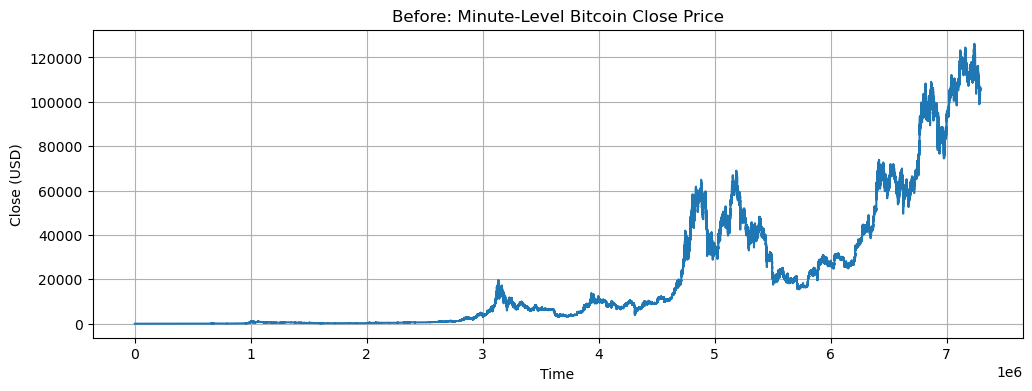

In [15]:
# A) Raw 1-minute close price
plt.figure(figsize=(12,4))
plt.plot(df.index, df["Close"])
plt.title("Before: Minute-Level Bitcoin Close Price")
plt.xlabel("Time"); plt.ylabel("Close (USD)")
plt.grid(True)
plt.show()

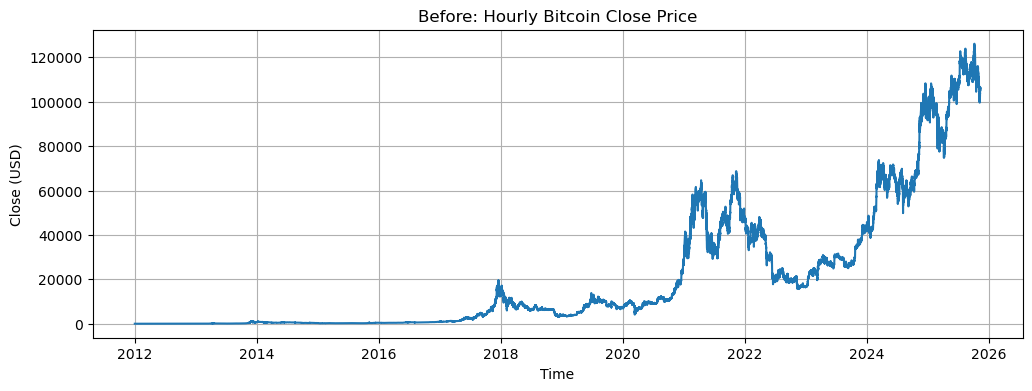

In [19]:
# B) Resample to hourly OHLCV
hourly = pd.DataFrame({
    "Open":   df["Open"].resample("H").first(),
    "High":   df["High"].resample("H").max(),
    "Low":    df["Low"].resample("H").min(),
    "Close":  df["Close"].resample("H").last(),
    "Volume": df["Volume"].resample("H").sum(),
}).dropna()

plt.figure(figsize=(12,4))
plt.plot(hourly.index, hourly["Close"])
plt.title("Before: Hourly Bitcoin Close Price")
plt.xlabel("Time"); plt.ylabel("Close (USD)")
plt.grid(True)
plt.show()

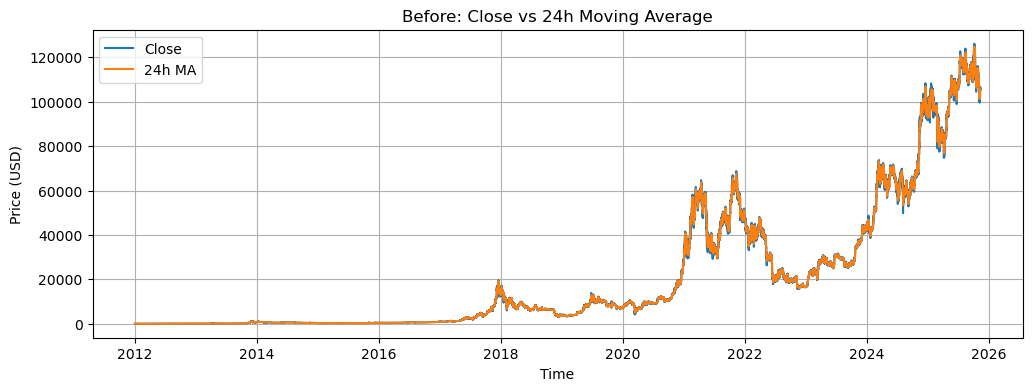

In [20]:
# C) 24-hour moving average
hourly["MA_24"] = hourly["Close"].rolling(24).mean()

plt.figure(figsize=(12,4))
plt.plot(hourly.index, hourly["Close"], label="Close")
plt.plot(hourly.index, hourly["MA_24"], label="24h MA")
plt.title("Before: Close vs 24h Moving Average")
plt.xlabel("Time"); plt.ylabel("Price (USD)")
plt.legend(); plt.grid(True)
plt.show()

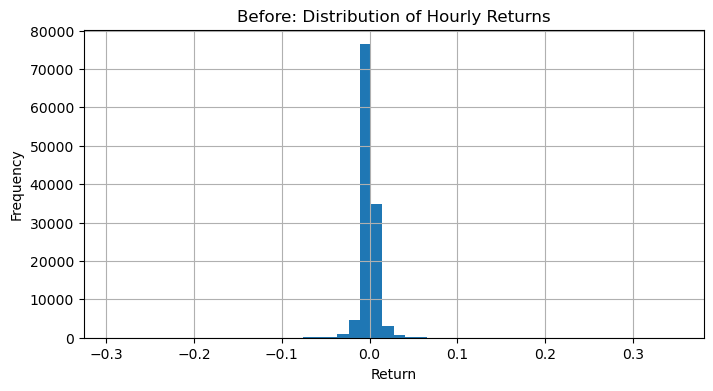

In [21]:
hourly["Return_1h"] = hourly["Close"].pct_change()

plt.figure(figsize=(8,4))
hourly["Return_1h"].dropna().hist(bins=50)
plt.title("Before: Distribution of Hourly Returns")
plt.xlabel("Return"); plt.ylabel("Frequency")
plt.show()


# Feature Engineering

In [24]:
data = hourly.copy()

# Lag features (past 24 hours)
for lag in range(1, 25):
    data[f"lag_{lag}"] = data["Close"].shift(lag)

# Rolling windows
data["roll_mean_6"] = data["Close"].rolling(6).mean()
data["roll_std_6"]  = data["Close"].rolling(6).std()
data["roll_mean_24"] = data["Close"].rolling(24).mean()
data["roll_std_24"]  = data["Close"].rolling(24).std()

# Target = next-hour close
data["y_next"] = data["Close"].shift(-1)

data = data.dropna()
data.head()



,Open,High,Low,Close,Volume,MA_24,Return_1h,lag_1,lag_2,lag_3,...,lag_20,lag_21,lag_22,lag_23,lag_24,roll_mean_6,roll_std_6,roll_mean_24,roll_std_24,y_next
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-02 10:00:00,5.0,5.0,5.0,5.0,0.0,4.795833,0.0,5.0,5.0,5.0,...,4.58,4.58,4.58,4.58,4.58,5.0,0.0,4.795833,0.182540,5.0
2012-01-02 11:00:00,5.0,5.0,5.0,5.0,0.0,4.813333,0.0,5.0,5.0,5.0,...,4.58,4.58,4.58,4.58,4.58,5.0,0.0,4.813333,0.181076,5.0
2012-01-02 12:00:00,5.0,5.0,5.0,5.0,0.0,4.830833,0.0,5.0,5.0,5.0,...,4.58,4.58,4.58,4.58,4.58,5.0,0.0,4.830833,0.177811,5.0
2012-01-02 13:00:00,5.0,5.0,5.0,5.0,0.0,4.848333,0.0,5.0,5.0,5.0,...,4.58,4.58,4.58,4.58,4.58,5.0,0.0,4.848333,0.172644,5.0
2012-01-02 14:00:00,5.0,5.0,5.0,5.0,0.0,4.865833,0.0,5.0,5.0,5.0,...,4.58,4.58,4.58,4.58,4.58,5.0,0.0,4.865833,0.165396,5.0


# Create Features & Train/Test Split

In [25]:
feature_cols = [c for c in data.columns if c.startswith("lag_")] + [
    "roll_mean_6", "roll_std_6",
    "roll_mean_24", "roll_std_24",
    "Volume"
]

X = data[feature_cols].values
y = data["y_next"].values
t = data.index

split_idx = int(len(data) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
t_train, t_test = t[:split_idx], t[split_idx:]

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


Shapes:
X_train: (97167, 29)
X_test : (24292, 29)


# Train Model

In [26]:
model = Ridge(alpha=5.0)
model.fit(X_train, y_train)

pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = math.sqrt(mean_squared_error(y_test, pred))

print("MAE :", mae)
print("RMSE:", rmse)


MAE : 210.54097283280558
RMSE: 354.6535352373022


In [28]:
pred[:10]   # first 10 predictions

array([23564.36431842, 23679.41880591, 23713.13073395, 23734.76909867,
       24190.17575571, 23957.03243602, 23899.98835164, 23843.66875552,
       23901.77010982, 23821.26722743])

In [31]:
print("t_test:", len(t_test))
print("y_test:", len(y_test))
print("pred:", len(pred))
print("NaNs in y_test:", np.isnan(y_test).sum())


t_test: 24292
y_test: 24292
pred: 24292
NaNs in y_test: 0


# Visualize Actual vs Predicted

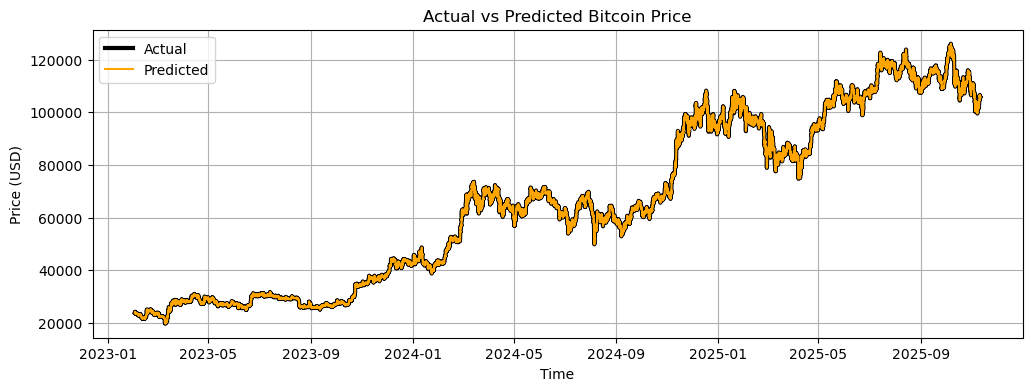

In [32]:
plt.figure(figsize=(12,4))
plt.plot(t_test, y_test, label="Actual", linewidth=3, color="black")
plt.plot(t_test, pred, label="Predicted", linewidth=1.5, color="orange")
plt.title("Actual vs Predicted Bitcoin Price")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


# Actual and Predicted values are very close to each other

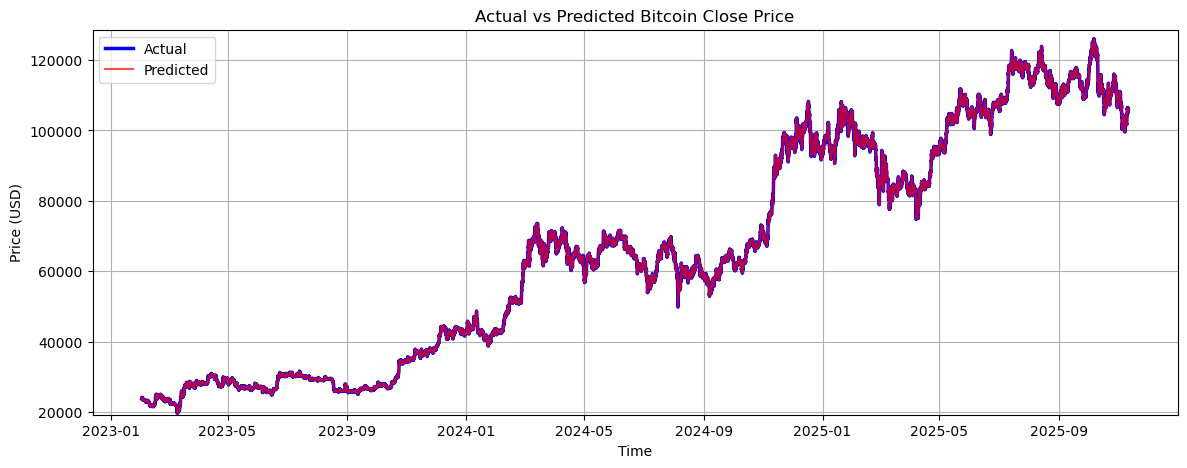

In [35]:
plt.figure(figsize=(14,5))

plt.plot(t_test, y_test, label="Actual", linewidth=2.5, color="blue")
plt.plot(t_test, pred, label="Predicted", linewidth=1.5, color="red", alpha=0.7)

plt.title("Actual vs Predicted Bitcoin Close Price")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)

# Ensure both lines are visible
plt.ylim(
    min(min(y_test), min(pred)) * 0.98,
    max(max(y_test), max(pred)) * 1.02
)

plt.show()


# We can verify the values

In [36]:
print("Actual sample:", y_test[:20])
print("Predicted sample:", pred[:20])


Actual sample: [23687. 23719. 23735. 24190. 23961. 23887. 23856. 23888. 23809. 23795.
 23789. 23807. 23838. 23786. 23829. 23805. 23767. 23615. 23847. 23793.]
Predicted sample: [23564.36431842 23679.41880591 23713.13073395 23734.76909867
 24190.17575571 23957.03243602 23899.98835164 23843.66875552
 23901.77010982 23821.26722743 23797.00281333 23804.55227444
 23800.53049942 23841.0767064  23778.6937832  23823.00721743
 23797.4263202  23751.40568407 23617.4017742  23851.09184644]


# Evaluate Model Performance

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

mae = mean_absolute_error(y_test, pred)
rmse = math.sqrt(mean_squared_error(y_test, pred))

print("MAE :", mae)
print("RMSE:", rmse)


MAE : 210.54097283280558
RMSE: 354.6535352373022


In [39]:
actual_dir = np.sign(np.diff(y_test))
pred_dir   = np.sign(np.diff(pred))

direction_accuracy = (actual_dir == pred_dir).mean()
direction_accuracy


0.475649417479725

# Plot the Residuals (To Check Errors Over Time)

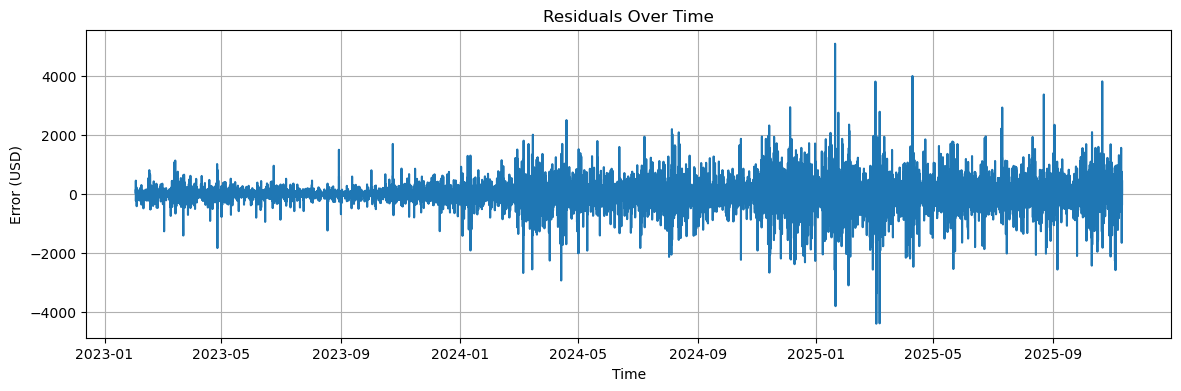

In [40]:
residuals = y_test - pred

plt.figure(figsize=(14,4))
plt.plot(t_test, residuals)
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Error (USD)")
plt.grid(True)
plt.show()


# Plot Error Distribution

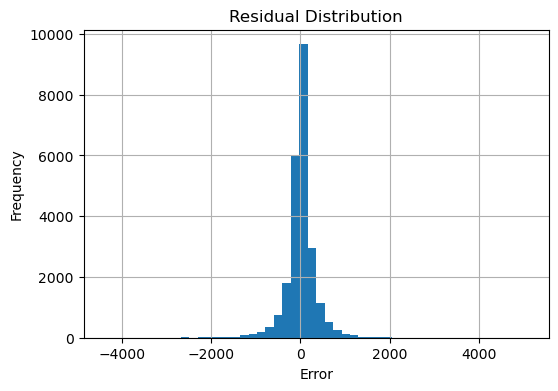

In [41]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Forecast future prices

In [46]:
import warnings
warnings.filterwarnings("ignore")
last_row = data.iloc[-1:].copy()
future_prediction = model.predict(last_row[feature_cols])[0]

print("Next-hour predicted BTC price:", future_prediction)


Next-hour predicted BTC price: 106007.31583982057


# Forecast plot

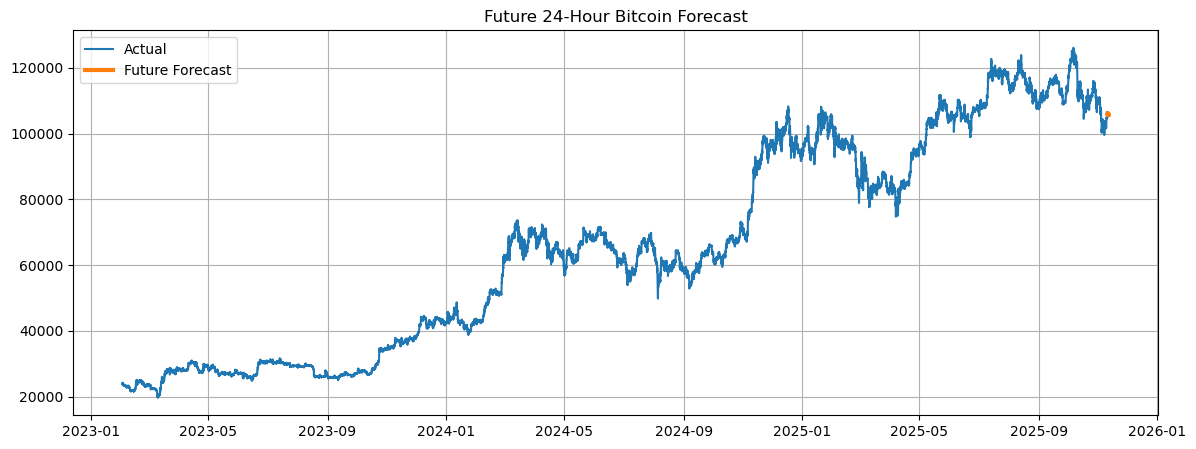

In [45]:
import warnings
warnings.filterwarnings("ignore")
future_steps = 24
future_prices = []

current_row = data.iloc[-1:].copy()

for i in range(future_steps):
    next_p = model.predict(current_row[feature_cols])[0]
    future_prices.append(next_p)

    # shift lag features by 1 hour
    for lag in range(24, 1, -1):
        current_row[f"lag_{lag}"] = current_row[f"lag_{lag-1}"]
    current_row["lag_1"] = next_p

# Create timeline
last_time = data.index[-1]
future_index = [last_time + pd.Timedelta(hours=i+1) for i in range(future_steps)]

plt.figure(figsize=(14,5))
plt.plot(t_test, y_test, label="Actual")
plt.plot(future_index, future_prices, label="Future Forecast", linewidth=3)
plt.title("Future 24-Hour Bitcoin Forecast")
plt.legend()
plt.grid(True)
plt.show()
